# Clustering NoteBook
We perform clustering analysis on Fashion MNIST and MNIST Digits

In [59]:
!pip install umap-learn
!pip install hdbscan
!pip install opentsne

In [60]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [61]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 30 14:08:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |    349MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import hdbscan

from sklearn.datasets import load_digits
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.datasets import fetch_openml

from sklearn.decomposition import PCA
from sklearn.utils import resample
from tensorflow.keras.datasets.fashion_mnist import load_data

#Import all the algorithms
from umap import UMAP
from sklearn.manifold import TSNE
from openTSNE import TSNE as OpenTSNE
from tqdm import tqdm

import time
%matplotlib inline

In [77]:
sns.set(context='paper', font='Arial', rc={'figure.figsize':(18,12)})

In [63]:
fashion = fetch_openml('Fashion-MNIST', version=1)
X_f = fashion.data
y_f = fashion.target.astype('int')

digits = fetch_openml('mnist_784')
X_d = digits.data
y_d = digits.target.astype('int')

In [65]:
pca = PCA()
PCA_f = pca.fit(X_f)
PCA_d = pca.fit(X_d)

In [66]:
count_f = 0
var_f = 0
for i in range(len(PCA_f.explained_variance_ratio_)):
  var_f += PCA_f.explained_variance_ratio_[i]
  count_f += 1
  
  if var_f > 0.98:
    break
print(var_f, count_f)

count_d = 0
var_d = 0
for i in range(len(PCA_d.explained_variance_ratio_)):
  var_d += PCA_d.explained_variance_ratio_[i]
  count_d += 1

  if var_d > 0.98:
    break
print(var_d, count_d)

0.9800213049893107 260
0.9800213049893107 260


In [84]:
#Methods
tsne_random_init = OpenTSNE(initialization='random', random_state=42)
tsne_pca_init = OpenTSNE(random_state=42)
tsne_pca_init_lr = OpenTSNE(perplexity=X_d.shape[0]/100, learning_rate=X_d.shape[0]/12)
umap_random_init = UMAP(n_neighbors=30, min_dist=0, init='random',random_state=42)
umap_le_init = UMAP(n_neighbors=30, min_dist=0, random_state=42)

In [63]:
%%time
with tf.device('/device:GPU:0'):
  c_embedding_u_r = umap_random_init.fit_transform(X_d)
  c_embedding_u_le = umap_le_init.fit_transform(X_d)

In [77]:

random_cluster = sns.scatterplot(
    x=c_embedding_u_r[:,0], y=c_embedding_u_r[:,1],
    hue=y_d,
    palette=sns.color_palette("tab10", 10),
    data=X_d,
    legend="full",
    alpha=0.3
)
random_cluster.figure.savefig("RandomUMAPCluster.jpg")

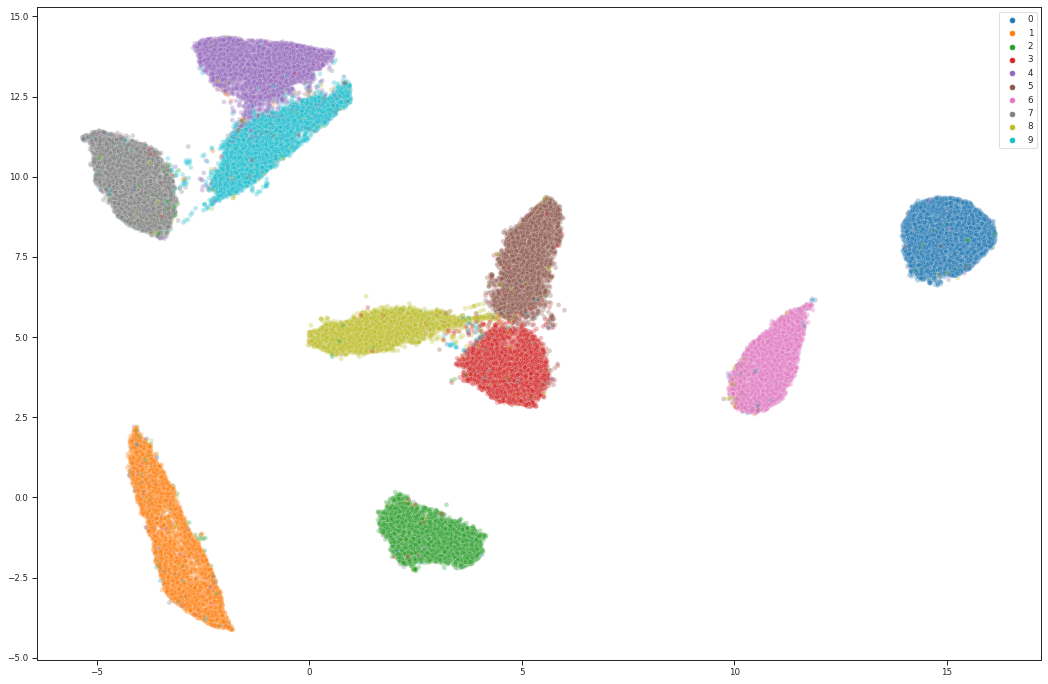

In [74]:
le_umap_plot = sns.scatterplot(
    x=c_embedding_u_le[:,0], y=c_embedding_u_le[:,1],
    hue=y_d,
    palette=sns.color_palette("tab10", 10),
    data=X_d,
    legend="full",
    alpha=0.3
)
le_umap_plot.figure.savefig("LeUMAPCluster.jpg")

In [78]:
labels_u_le_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_u_le)

labels_u_r_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_u_r)

In [79]:
print(adjusted_rand_score(y_d, labels_u_le_d), adjusted_mutual_info_score(y_d, labels_u_le_d))
print(adjusted_rand_score(y_d, labels_u_r_d), adjusted_mutual_info_score(y_d, labels_u_r_d))



0.928524312690162 0.9139877104198384
0.8403235361652511 0.8875355215040602


In [82]:
clustered_u_le_d = (labels_u_le_d >= 0)
print(adjusted_rand_score(y_d[clustered_u_le_d], labels_u_le_d[clustered_u_le_d]),
      adjusted_mutual_info_score(y_d[clustered_u_le_d], labels_u_le_d[clustered_u_le_d]))
clustered_u_r_d = (labels_u_r_d >= 0)
print(adjusted_rand_score(y_d[clustered_u_r_d], labels_u_r_d[clustered_u_r_d]),
      adjusted_mutual_info_score(y_d[clustered_u_r_d], labels_u_r_d[clustered_u_r_d]))

0.9316153844332764 0.9187021103541159
0.8428240317160364 0.8916644749742128


In [83]:
print(np.sum(clustered_u_le_d) / X_d.shape[0])
print(np.sum(clustered_u_r_d) / X_d.shape[0])

0.9969857142857143
0.9969857142857143


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


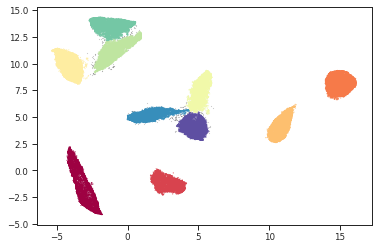

In [42]:
# HDB Scan noise vs Non-noise
clustered = (labels_u_le_d >= 0)
plt.scatter(c_embedding_u_le[~clustered, 0],
            c_embedding_u_le[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(c_embedding_u_le[clustered, 0],
            c_embedding_u_le[clustered, 1],
            c=labels_u_le_d[clustered],
            s=0.1,
            cmap='Spectral');

In [ ]:
%%time
with tf.device('/device:GPU:0'):
  c_embedding_t_pca = tsne_pca_init.fit(X_d)
  c_embedding_t_r = tsne_random_init.fit(X_d)

In [ ]:
sns.scatterplot(
    x=c_embedding_t_pca[:,0], y=c_embedding_t_pca[:,1],
    hue=y_d,
    palette=sns.color_palette("hls", 10),
    data=X_d,
    legend="full",
    alpha=0.3
)

In [ ]:
sns.scatterplot(
    x=c_embedding_t_r[:,0], y=c_embedding_t_r[:,1],
    hue=y_d,
    palette=sns.color_palette("hls", 10),
    data=X_d,
    legend="full",
    alpha=0.3
)

In [49]:
labels_t_pca_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_t_pca)

labels_t_r_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_t_r)

In [52]:
print(adjusted_rand_score(y_d, labels_t_pca_d), adjusted_mutual_info_score(y_d, labels_t_pca_d))
print(adjusted_rand_score(y_d, labels_t_r_d), adjusted_mutual_info_score(y_d, labels_t_r_d))

0.6857890650978186 0.8384602831554911
0.8277752600695114 0.8710894804457593


In [ ]:
clustered_t_pca_d = (labels_t_pca_d >= 0)
print(adjusted_rand_score(y_d[clustered_t_pca_d], labels_t_pca_d[clustered_t_pca_d]),
      adjusted_mutual_info_score(y_d[clustered_t_pca_d], labels_t_pca_d[clustered_t_pca_d]))
clustered_t_r_d = (labels_t_r_d >= 0)
print(adjusted_rand_score(y_d[clustered_t_r_d], labels_t_r_d[clustered_t_r_d]),
      adjusted_mutual_info_score(y_d[clustered_t_r_d], labels_t_r_d[clustered_t_r_d]))

In [ ]:
print(np.sum(clustered_t_pca_d) / X_d.shape[0])
print(np.sum(clustered_t_r_d) / X_d.shape[0])

In [56]:
%%time
with tf.device('/device:GPU:0'):
  c_embedding_t_pca_r = tsne_pca_init_lr.fit(X_d)

CPU times: user 1h 8min 19s, sys: 11.4 s, total: 1h 8min 30s
Wall time: 1h 8min 6s


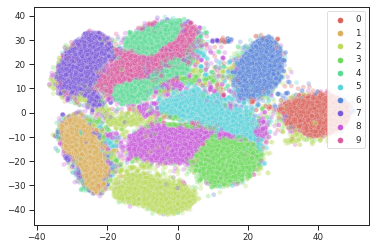

In [57]:
sns.scatterplot(
    x=c_embedding_t_pca_r[:,0], y=c_embedding_t_pca_r[:,1],
    hue=y_d,
    palette=sns.color_palette("hls", 10),
    data=X_d,
    legend="full",
    alpha=0.3
)

In [58]:
labels_t_pca_lr_d = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(c_embedding_t_pca_r)

print(adjusted_rand_score(y_d, labels_t_pca_lr_d), adjusted_mutual_info_score(y_d, labels_t_pca_lr_d))


0.5837016486034755 0.7513098995079329
